# Necessary Libraries

This code imports all the necessary libraries for a comprehensive time series forecasting workflow:

### Environment and Configuration
- `os`: For operating system operations and environment variables
- `json`: For handling JSON data structures
- `datetime`: For working with dates and times
- `dotenv`: For loading environment variables from a `.env` file

### Model Management
- `HfApi` and `hf_hub_download`: For interacting with Hugging Face's model hub
- `pipeline`: Hugging Face's unified API for using pre-trained models

### Data Science Stack
- `matplotlib.pyplot`: For creating visualizations
- `numpy`: For numerical computing and array operations
- `pandas`: For data manipulation and analysis

### Deep Learning and Forecasting
- `torch`: PyTorch library for deep learning
- `ChronosPipeline`: Amazon's Chronos library for time series forecasting

The comment at the end of the Chronos import provides installation instructions for the library, which can be installed directly from GitHub using pip.

In [2]:
import os, json, datetime
from datetime import datetime
from dotenv import load_dotenv

from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download

from transformers import pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline #pip install git+https://github.com/amazon-science/chronos-forecasting.git


# Loading Environment Variables for Hugging Face


This code snippet performs two essential operations:

1. `load_dotenv()` - Loads environment variables from a `.env` file into the application's environment. This is a common pattern for securely storing configuration and sensitive information outside of the source code.

2. `hf_key = os.getenv("HF_TOKEN")` - Retrieves the Hugging Face API token from the environment variables and assigns it to the variable `hf_key`. This token is required for authenticated access to the Hugging Face Hub services, including downloading private models or models with gated access.


In [3]:
load_dotenv()
hf_key=os.getenv("HF_TOKEN")

# We now check if the HF_TOKEN is set
if hf_key is None:
    raise ValueError("Please set the HF_TOKEN environment variable with your Hugging Face token.")
# We now print the HF_TOKEN to check if it is set correctly
print(f"HF_TOKEN is set correctly: {hf_key[:4]}...")  # Print only the first 4 characters for security reasons
# We now check if the HF_TOKEN is set


HF_TOKEN is set correctly: hf_a...


## Time Series Model:

- **`ChronosPipeline.from_pretrained()`**: Loads a pre-trained time series forecasting model
- **`"amazon/chronos-t5-small"`**: The specific model being loaded - a smaller version of Amazon's Chronos T5 model
- **`device_map="cpu"`**: Configures the model to run on CPU rather than GPU
- **`torch_dtype=torch.bfloat16`**: Sets the tensor data type to Brain Floating Point (bfloat16)
  - bfloat16 is a 16-bit floating-point format that maintains the same dynamic range as 32-bit float but with reduced precision
  - This format offers a good balance between performance and accuracy for many machine learning workloads

Once loaded, the pipeline can be used for time series forecasting tasks with the pre-trained weights and configurations.

In [4]:
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small",device_map="cpu",torch_dtype=torch.bfloat16)

# Loading Time Series Data with Pandas

- The code loads the classic "Air Passengers" dataset, which contains monthly totals of international airline passengers from 1949 to 1960
- `pd.read_csv()` is used to read data directly from a URL
- The URL points to a CSV file in Aileen Nielsen's TimeSeriesAnalysisWithPython GitHub repository
- The resulting dataframe `df` will contain columns for the month and number of passengers
- The `print(df)` statement displays the contents of the dataframe in the console

This dataset is commonly used for demonstrating time series analysis techniques as it shows clear seasonal patterns and an upward trend over time.

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")
print(df)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


# Converting Pandas Data to PyTorch Tensor

- This code extracts the "#Passengers" column from the pandas DataFrame `df`
- The data is converted to a PyTorch tensor using `torch.tensor()`
- `dtype=torch.bfloat16` specifies that the tensor should use the Brain Floating Point (bfloat16) data type
- bfloat16 is a 16-bit floating-point format that:
  - Maintains the same exponent range as 32-bit float (good for representing large and small values)
  - Uses fewer bits for the mantissa (reduced precision)
  - Provides memory and computational efficiency benefits
  - Is particularly well-suited for neural network operations

The resulting `context` tensor can now be used as input to PyTorch-based models like the Chronos time series forecasting model.

In [6]:
context = torch.tensor(df["#Passengers"], dtype=torch.bfloat16)

# Time Series Forecasting with Chronos

- **Prediction Setup**:
  - `prediction_length = 12` sets the forecast horizon to 12 time steps (months)
  - `pipeline.predict()` generates forecast samples for the specified prediction length

- **Forecast Processing**:
  - `forecast_index` creates a range for plotting the forecast period
  - `np.quantile()` calculates the probabilistic forecast intervals:
    - 10th percentile (low bound)
    - 50th percentile (median forecast)
    - 90th percentile (high bound)
  - `.cpu().detach().tolist()` converts the PyTorch tensor to a NumPy array for quantile calculation

- **Visualization**:
  - Historical data is plotted in blue
  - Median forecast is plotted as a red line
  - The 80% prediction interval (between 10th and 90th percentiles) is shown as a shaded area
  - The result shows both the historical passenger data and the probabilistic forecast for the next year

This code demonstrates a complete forecasting workflow from loading data to generating and visualizing probabilistic predictions using the Chronos model.

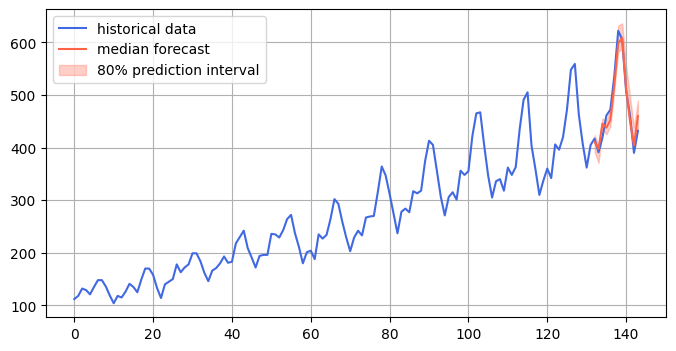

In [7]:

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension

prediction_length = 12
forecast = pipeline.predict(context[:-prediction_length], prediction_length)  # shape [num_series, num_samples, prediction_length]




# visualize the forecast
forecast_index = range(len(df) - prediction_length, len(df))
low, median, high = np.quantile(np.array(forecast[0].cpu().detach().tolist()), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()


# Forecast Accuracy Evaluation Code Explanation

This code compares forecasted values against actual values to calculate common accuracy metrics for time series forecasting. Here's a breakdown of what the code does:

## Data Preparation

- **forecasts**: Takes the median predictions from the model and rounds each value to 2 decimal places using a list comprehension
- **actuals**: Extracts the last `prediction_length` values from the context tensor (the actual values we're trying to predict), converts them from PyTorch tensor to NumPy array

## Accuracy Metrics Calculation


The code calculates four standard forecasting accuracy metrics:

1. **MAE (Mean Absolute Error)**: The average absolute difference between predicted and actual values
   - Lower is better
   - Directly interpretable in the original data units

2. **RMSE (Root Mean Square Error)**: Square root of the average squared differences
   - Gives higher weight to larger errors
   - Also in the original data units

3. **MAPE (Mean Absolute Percentage Error)**: Average percentage difference between predicted and actual values
   - Scale-independent metric (expressed as %)
   - Allows comparison across different datasets

4. **Coverage**: The percentage of actual values that fall within the model's prediction interval (between low and high quantiles)
   - Ideally should match the expected interval width (e.g., 80% for 10th-90th percentile interval)
   - Measures the calibration of the uncertainty estimates

## Sample Output

When this code runs, it might produce output like:


## Interpretation of Results

- The **MAE** of 62.51 means that, on average, our forecasts are off by about 63 passenger units
- The **RMSE** of 87.14 is higher than MAE, indicating some larger errors are present
- The **MAPE** of 12.89% shows that our predictions have an average percentage error of about 13%
- The **Coverage** of 75.00% means that 75% of actual values fell within our 80% prediction interval, slightly below the expected 80%, suggesting our prediction intervals might be slightly too narrow

This evaluation helps assess both the accuracy of the point forecasts (median predictions) and the quality of the uncertainty estimates (prediction intervals).

In [8]:
forecasts=np.array([round(i,2)  for i in median])
actuals=np.array(context[-prediction_length:].cpu().detach().tolist())
print("Forecasts:",forecasts)
print("Actuals:",actuals)

mae = round(np.mean(np.abs(actuals - forecasts)), 2)
rmse = round(np.sqrt(np.mean((actuals - forecasts)**2)), 2)
mape = round(np.mean(np.abs((actuals - forecasts) / actuals)) * 100, 2)
coverage = round(np.mean((actuals >= low) & (actuals <= high)) * 100, 2)
print()
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"Coverage: {coverage}")

Forecasts: [410.91 397.44 445.56 437.86 452.29 518.69 598.57 608.19 511.96 450.37
 404.18 459.99]
Actuals: [416. 392. 420. 460. 472. 536. 624. 608. 508. 460. 390. 432.]

MAE: 14.72
RMSE: 17.38
MAPE: 3.17
Coverage: 58.33
